# Fitting the mean and variance of Praesepe.

In [813]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 20,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [919]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
logp = np.log10(pr.prot[m])
err = .434 * .1
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)
subcut = 450
eep = np.random.uniform(200, subcut, len(logp))

Add the Sun.

In [920]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])
sun_err, sun_eep = np.array([.0001]), np.array([355])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, sun_err))
eep_sun = np.concatenate((eep, sun_eep))

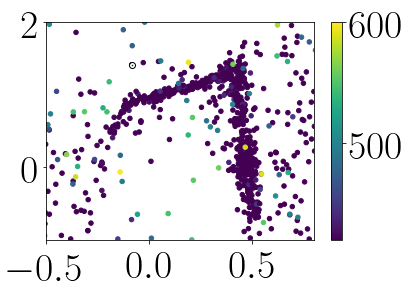

In [921]:
# Now augment the data with hot stars, cool stars and giants.
nhot, ncool, nsub = 150, 400, 500
giant_eeps = np.random.uniform(subcut, 600, nsub)

# Color
# logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, -.3, nhot), np.random.uniform(.58, 1.2, ncool)))
logbprp_aug = np.concatenate((logbprp_sun, np.random.uniform(-1, -.25, nhot), np.random.uniform(.4, 1.2, ncool),
                              np.random.uniform(-1, 1.2, nsub)))

# Period
logp_aug = np.concatenate((logp_sun, np.random.randn(nhot)*1 - .5, np.random.randn(ncool)*2 - .5,
                           np.random.randn(nsub)*(2*(giant_eeps/100.) - (subcut/100.))))
# logp_aug = np.concatenate((logp_sun, np.random.randn(nhot)*1 - .5, np.random.randn(ncool)*1 - .5))

# Age
log_age_aug = np.concatenate((log_age_sun, np.ones(nhot)*np.log10(650*1e6), np.ones(ncool)*np.log10(650*1e6),
                              np.ones(nsub)*np.log10(650*1e6)))

# Period_err
logp_err_aug = np.concatenate((logp_err_sun, np.ones(nhot)*err, np.ones(ncool)*err,
                               np.ones(nsub)*err))

# EEP
eep_aug = np.concatenate((eep_sun, np.random.uniform(200, 420, nhot), np.random.uniform(200, 420, ncool),
                          giant_eeps))

plt.scatter(logbprp_aug, logp_aug, c=eep_aug, s=20, vmin=420, vmax=600)
plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k")
plt.plot(sun_color, sun_prot, "k.", ms=1)
plt.ylim(-1, 2)
plt.xlim(-.5, .8)
plt.colorbar();

Text(0, 0.5, 'log(period)')

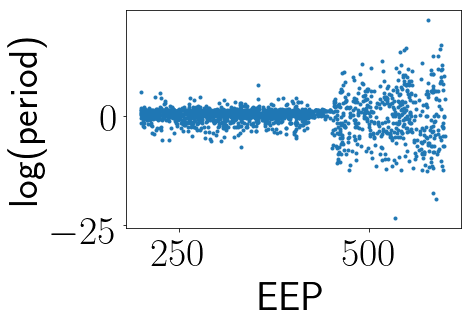

In [922]:
plt.plot(eep_aug, logp_aug, ".")
plt.xlabel("EEP")
plt.ylabel("log(period)")

In [923]:
def model(p, log_c, log_age):
    return np.polyval(p[:20], log_c) + p[20]*log_age

def variance(p, log_c, eep, prot_err):
    z = eep/100.
#     return (prot_err + np.polyval(p[21:24], log_c))**2
    return (prot_err + np.polyval(p[21:24], log_c) + np.polyval(p[24:], z))**2

In [924]:
def lnlike(p, log_c, log_prot, log_age, eep, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, eep, prot_err)
    return np.sum(-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))

def nll(p, log_c, log_prot, log_age, eep, prot_err):
    mod = model(p, log_c, log_age)
    var = variance(p, log_c, eep, prot_err)
    return np.sum((-.5 * (mod - log_prot)**2/var - .5*np.log(2*np.pi*var))*-1)

In [925]:
p0 = np.ones(28)
# print(np.shape(logbprp_aug), np.shape(logp_aug), np.shape(log_age_aug), np.shape(eep), np.)
results = sco.minimize(nll, p0, args=(logbprp_aug, logp_aug, log_age_aug, eep_aug, logp_err_aug))
print(results.x)

[-1.46847020e+02  3.75118965e+02  5.83889898e+01 -5.19888609e+02
  3.87225189e+01 -2.60114772e+02  4.08980459e+02  4.86727628e+02
 -1.01633871e+02  2.48993514e+02 -9.19004877e+02 -5.65070664e+02
  9.80490424e+02  2.89288484e+02 -3.66340047e+02 -5.16083711e+01
  4.46907532e+01 -3.22978992e+00  7.94380865e-01 -5.42115336e+00
  7.20385154e-01  3.24458858e+00  2.22950681e-02 -4.40015501e+00
  4.18486159e-01 -3.56515030e+00  9.89820155e+00 -4.40015502e+00]


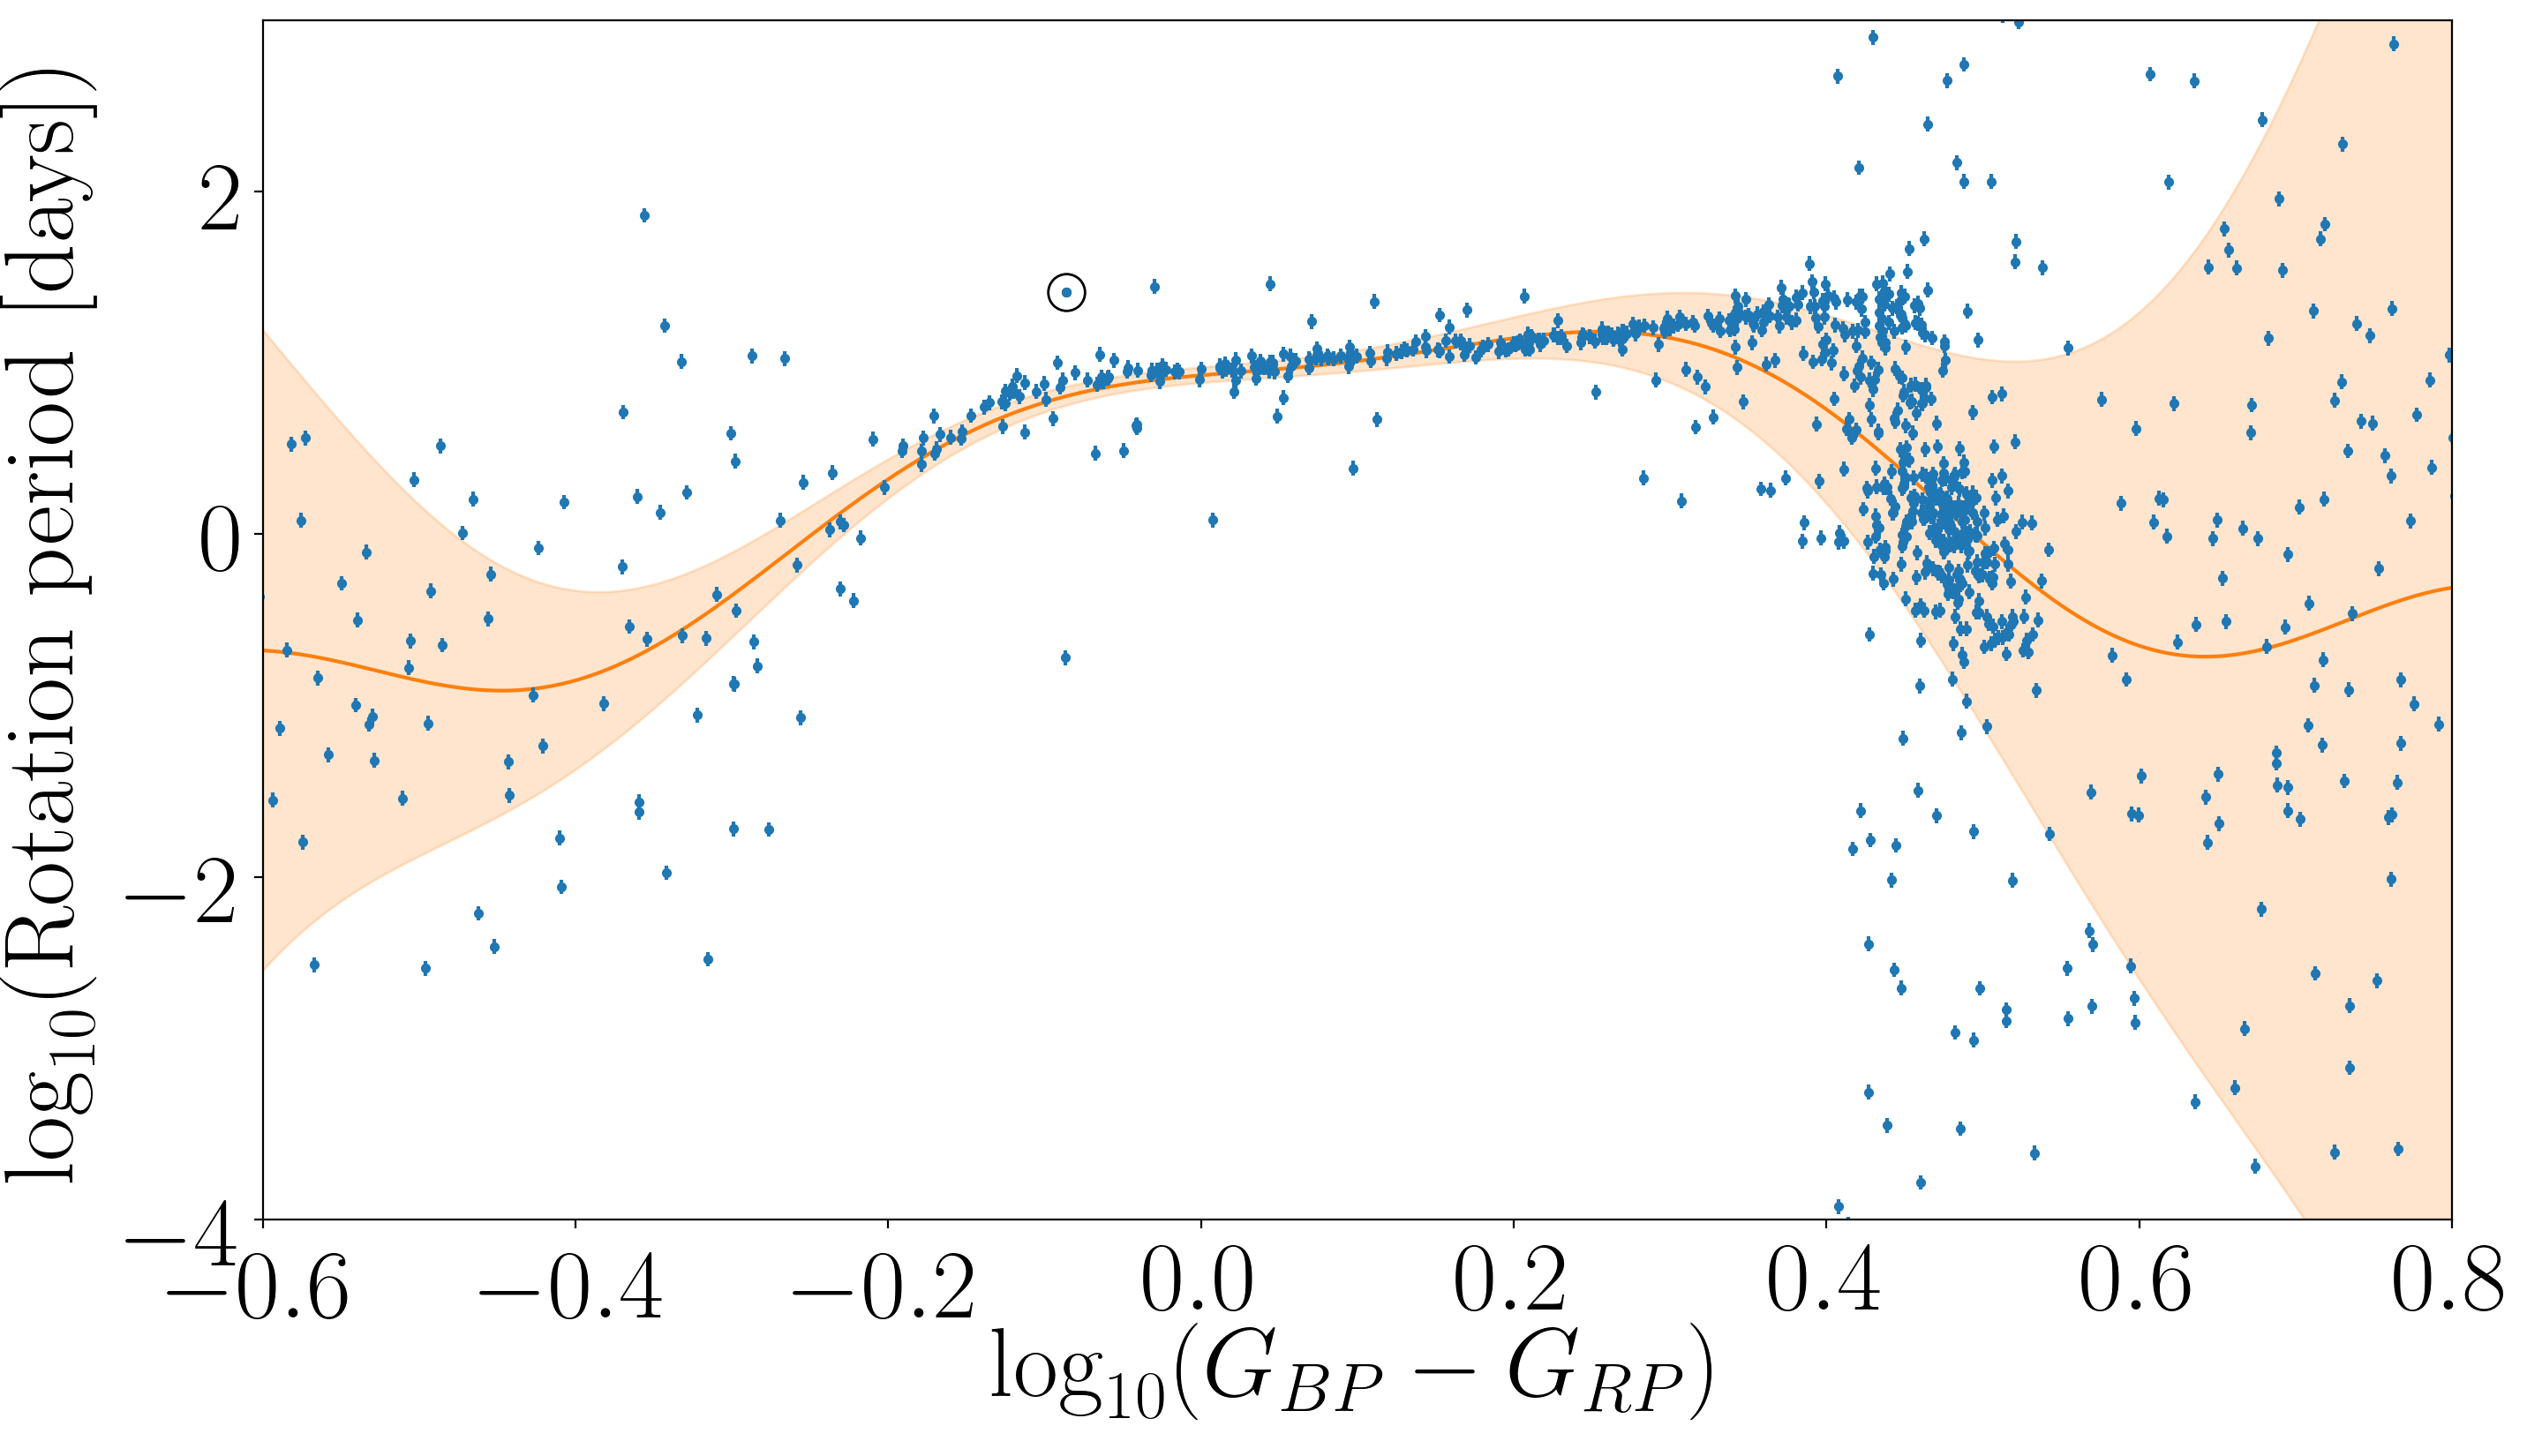

In [938]:
plt.figure(figsize=(16, 9), dpi=200)
dwarfs = eep_aug < subcut
plt.errorbar(logbprp_aug[dwarfs], logp_aug[dwarfs], yerr=logp_err_aug[dwarfs], fmt=".");
plt.plot(x, model(results.x, x, np.log10(650*1e6)), zorder=1)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2)
plt.plot(sun_color, sun_prot, ".k", zorder=2)

mean, var = model(results.x, x, np.log10(650*1e6)), variance(results.x, x, 350, np.ones_like(x)*.1);
plt.fill_between(x, mean + var, mean - var, alpha=.2, color="C1", zorder=0);
plt.xlim(-.6, .8)
plt.ylim(-4, 3)
plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$");

Text(0, 0.5, '$\\mathrm{Variance~[days^2]}$')

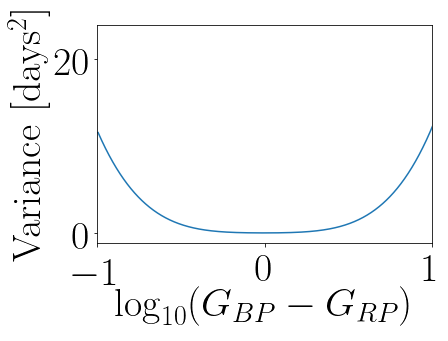

In [940]:
plt.plot(x, var)
plt.xlim(-1, 1)
plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\mathrm{Variance~[days^2]}$")

Text(0, 0.5, 'log(period)')

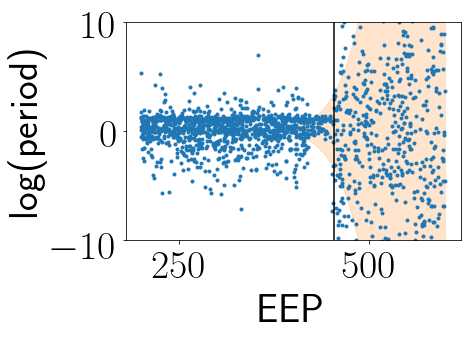

In [935]:
def eep_variance(p, log_c, logprot_err):
    return (logprot_err + np.polyval(p, log_c))**2

eep_x = np.linspace(200, 600, 100)
eep_mean = np.zeros(len(eep_x))
eep_var = variance(results.x, 0., eep_x, err)

# plt.figure(figsize=(16, 9))
plt.plot(eep_aug, logp_aug, ".")

plt.fill_between(eep_x, eep_mean + eep_var, eep_mean - eep_var, alpha=.2, color="C1");
plt.axvline(454, color="k")
plt.ylim(-10, 10)

plt.xlabel("EEP")
plt.ylabel("log(period)")

(0, 60)

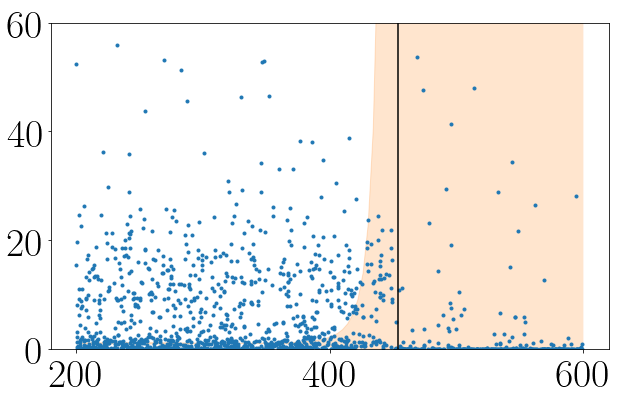

In [937]:
plt.figure(figsize=(10, 6))
plt.plot(eep_aug, 10**logp_aug, ".")
plt.fill_between(eep_x, 10**(eep_mean + eep_var), 10**(eep_mean - eep_var), alpha=.2, color="C1");
plt.axvline(454, color="k")
plt.ylim(0, 60)

Now make up some data that allows you to have a smoothly increasing variance for EEP.

In [822]:
# neep = 100
# cut = 4.2
# subgiant_eeps = np.random.uniform(cut, 6, neep)
# eeps = np.concatenate((np.random.uniform(2, cut, len(logbprp)), subgiant_eeps))
# eep_prot = np.concatenate((np.zeros(len(logp))+np.random.randn(len(logp))*.05, 
#                            np.random.randn(neep)*(1.5*subgiant_eeps - cut)))  # This is invented

# def eep_model(p, log_c):
#     return np.zeros(len(log_c))

# def eep_variance(p, log_c, logprot_err):
#     return (logprot_err + np.polyval(p, log_c))**2
            
# def eep_nll(p, log_c, logprot, logprot_err):
#     mod = eep_model(p, log_c)
#     var = eep_variance(p, log_c, logprot_err)
#     return np.sum((-.5 * (mod - logprot)**2/var - .5*np.log(2*np.pi*var)))*-1

# eep_p0 = 1e-2*np.ones(4)
# yerr = err * np.ones_like(eep_prot)

In [936]:
# eep_results = sco.minimize(eep_nll, eep_p0, args=(eeps, eep_prot, yerr))
# print(eep_results.x)

# eep_mean = eep_model(eep_results.x, eep_x)
# eep_var = eep_variance(eep_results.x, eep_x, err)

# # plt.figure(figsize=(16, 9))
# plt.plot(eeps, eep_prot, ".")
# plt.fill_between(eep_x, eep_mean + eep_var, eep_mean - eep_var, alpha=.2, color="C1");
# plt.axvline(4.54, color="k")

In [941]:
# plt.figure(figsize=(10, 6))
# plt.plot(eeps, 10**eep_prot, ".")
# plt.fill_between(eep_x, 10**(eep_mean + eep_var), 10**(eep_mean - eep_var), alpha=.2, color="C1");
# plt.axvline(4.54, color="k")
# plt.ylim(0, 60)

Simulate stars from this model to check that things look reasonable.

In [942]:
# def total_variance(p, log_c, eep, logp_err):
#     z = eep/100.
#     return (logp_err + np.polyval(p[21:24], log_c))**2 + (logp_err + np.polyval(p[24:], z))**2

# # (prot_err + np.polyval(p[21:24], log_c))**2

# def generative_model(p, log_c, log_age, eep, logp_err):
#     z = eep/100.
#     mean = model(p, log_c, log_age)
#     var = total_variance(p, log_c, z, logp_err)
#     return mean + np.random.randn(len(log_c))*var

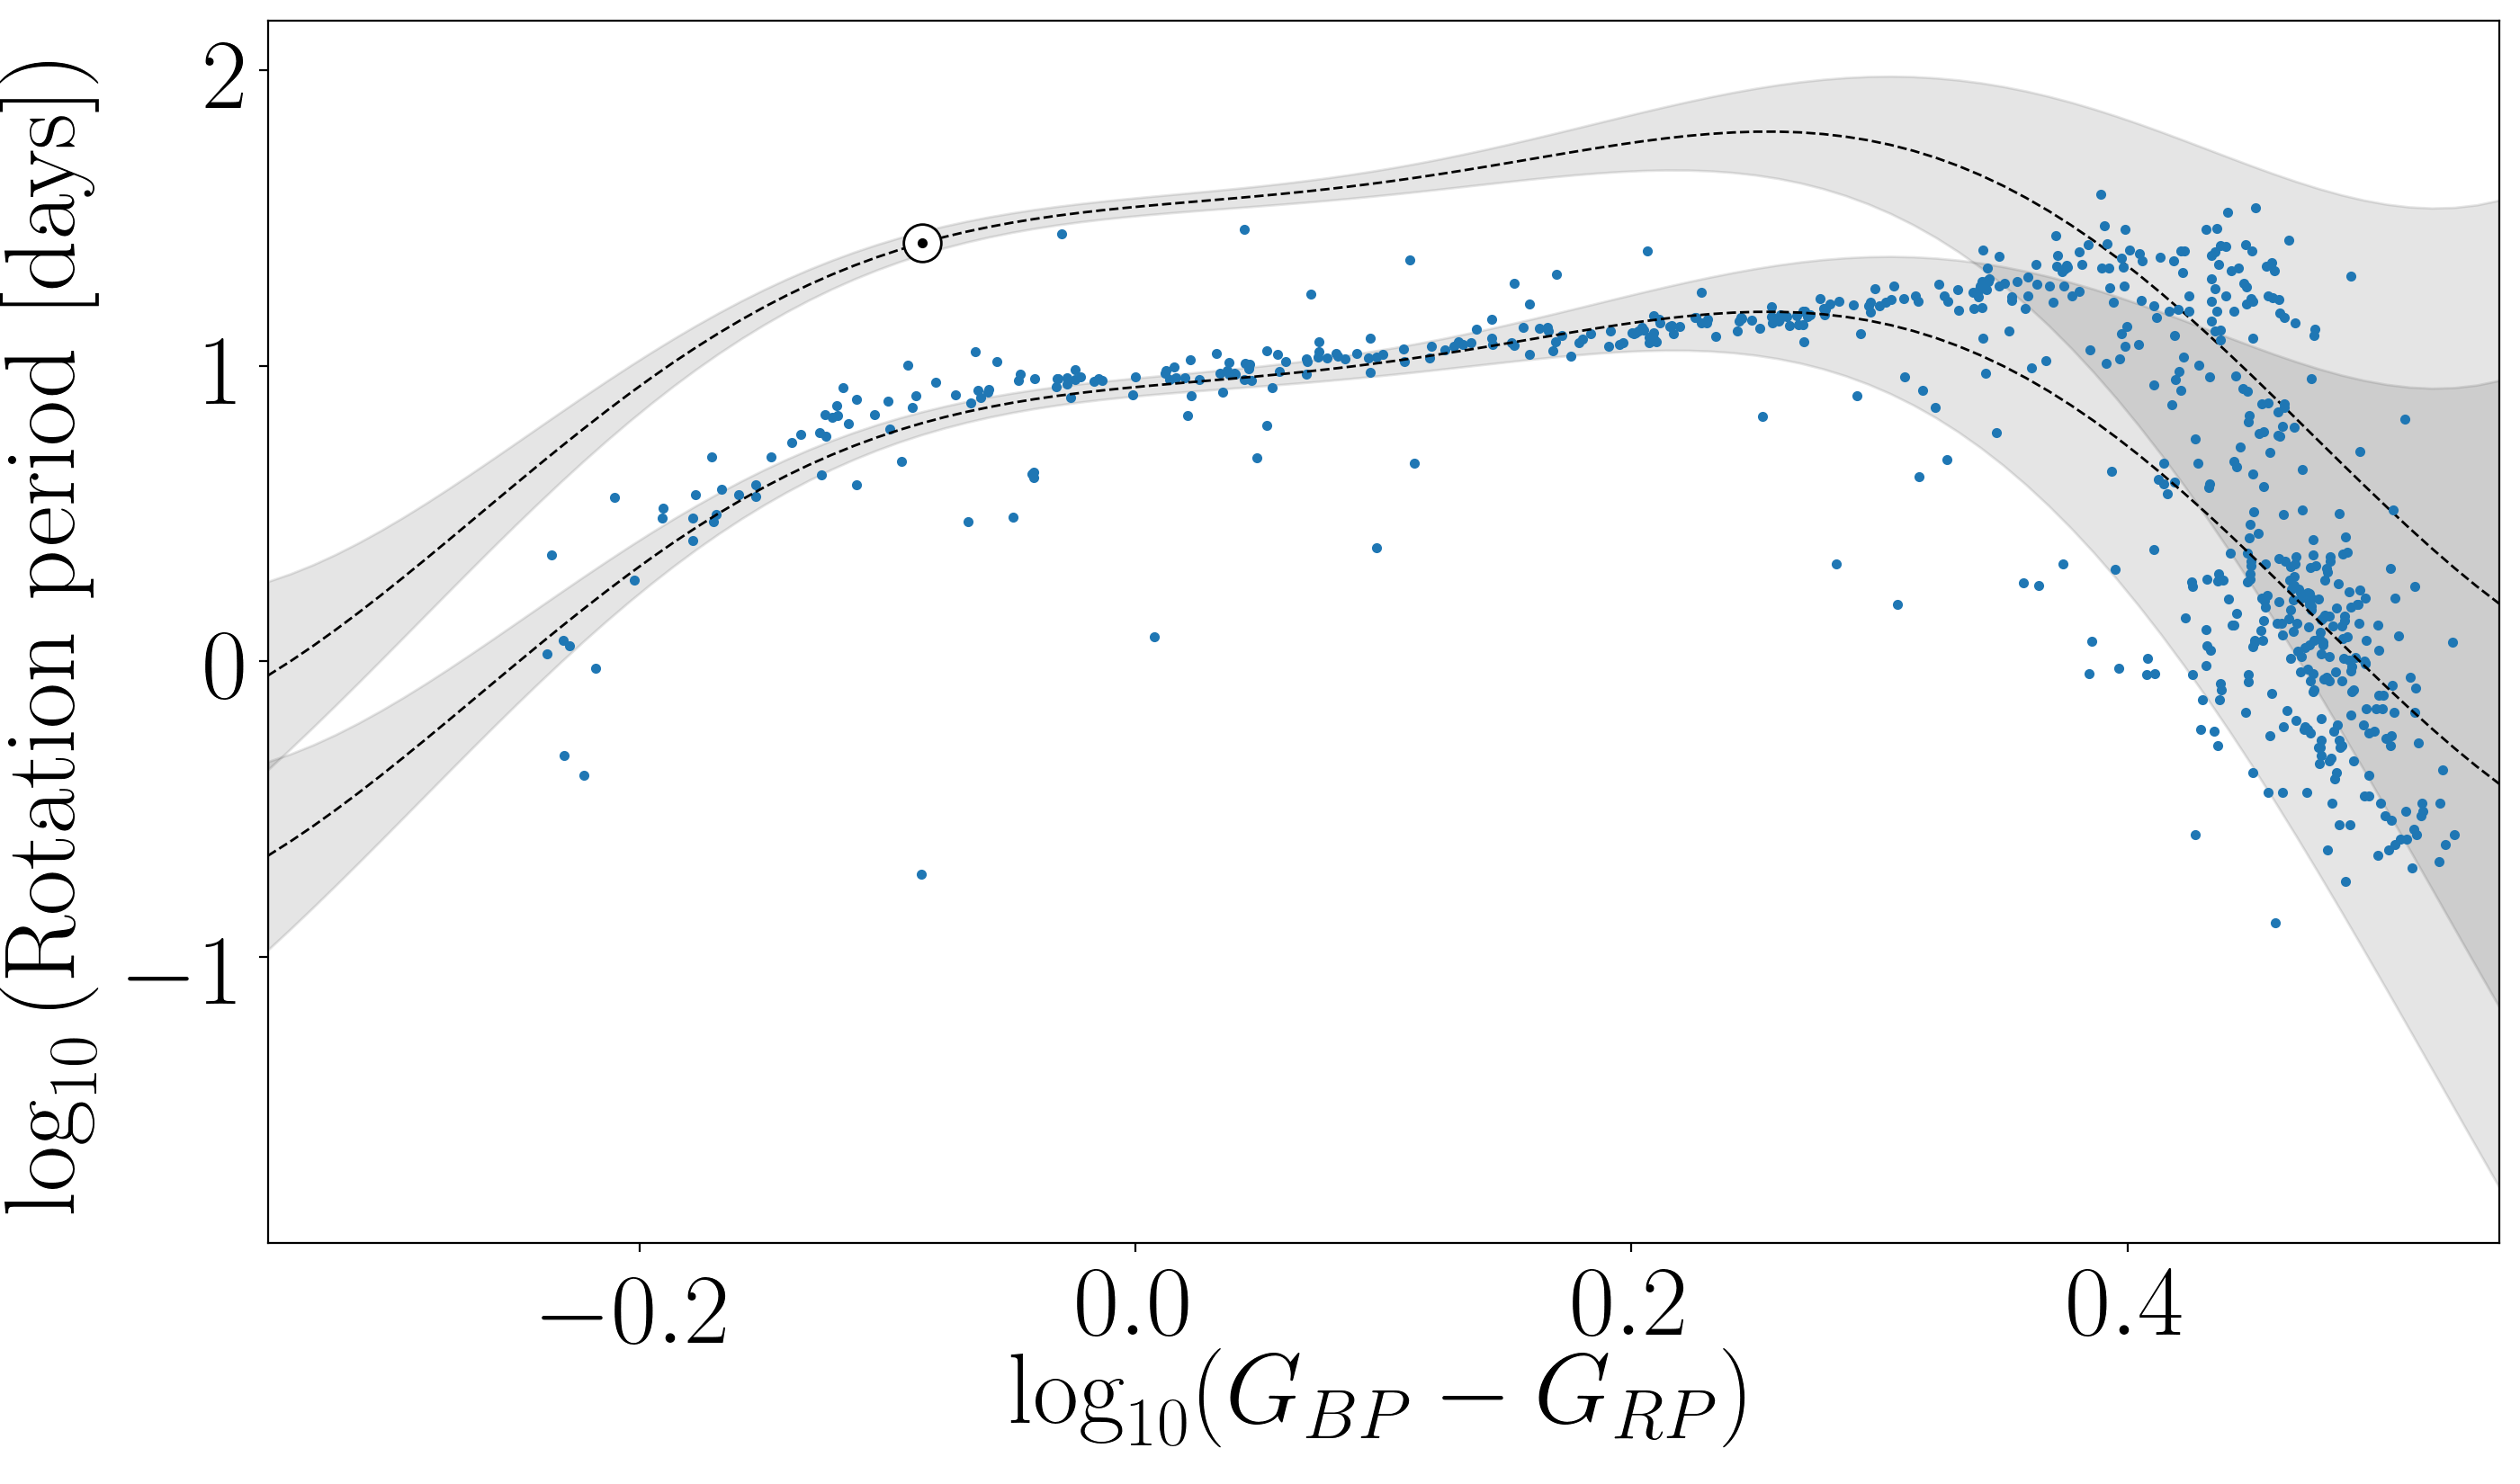

In [946]:
best_fit = results.x

plt.figure(figsize=(16, 9), dpi=200)
plt.plot(logbprp, logp, ".")
# dwarfs = generative_model(best_fit, logbprp, np.log10(650*1e6), np.ones_like(logbprp)*250, logp_err)
# plt.plot(logbprp, dwarfs, ".")

plot_x = np.linspace(-.35, .55, 100)
mean_praesepe = model(best_fit, plot_x, np.log10(650*1e6))
plot_var = variance(best_fit, plot_x, np.ones_like(plot_x)*355, np.ones_like(plot_x)*err)

plt.plot(plot_x, mean_praesepe, color="k", ls="--", lw=1, rasterized=True)
plt.fill_between(plot_x, mean_praesepe + plot_var, mean_praesepe - plot_var, color="k", alpha=.1, rasterized=True)

plt.plot(sun_color, sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.plot(sun_color, sun_prot, ".k", zorder=2, rasterized=True)

mean_sun = model(best_fit, plot_x, np.log10(4.56*1e9))
plt.plot(plot_x, mean_sun, color="k", ls="--", lw=1, zorder=0, rasterized=True)
plt.fill_between(plot_x, mean_sun + plot_var, mean_sun - plot_var, color="k", alpha=.1, rasterized=True)
plt.xlim(-.35, .55)

plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}\mathrm{(Rotation~period~[days])}$");

Now as a loglog plot so the axes make more sense.

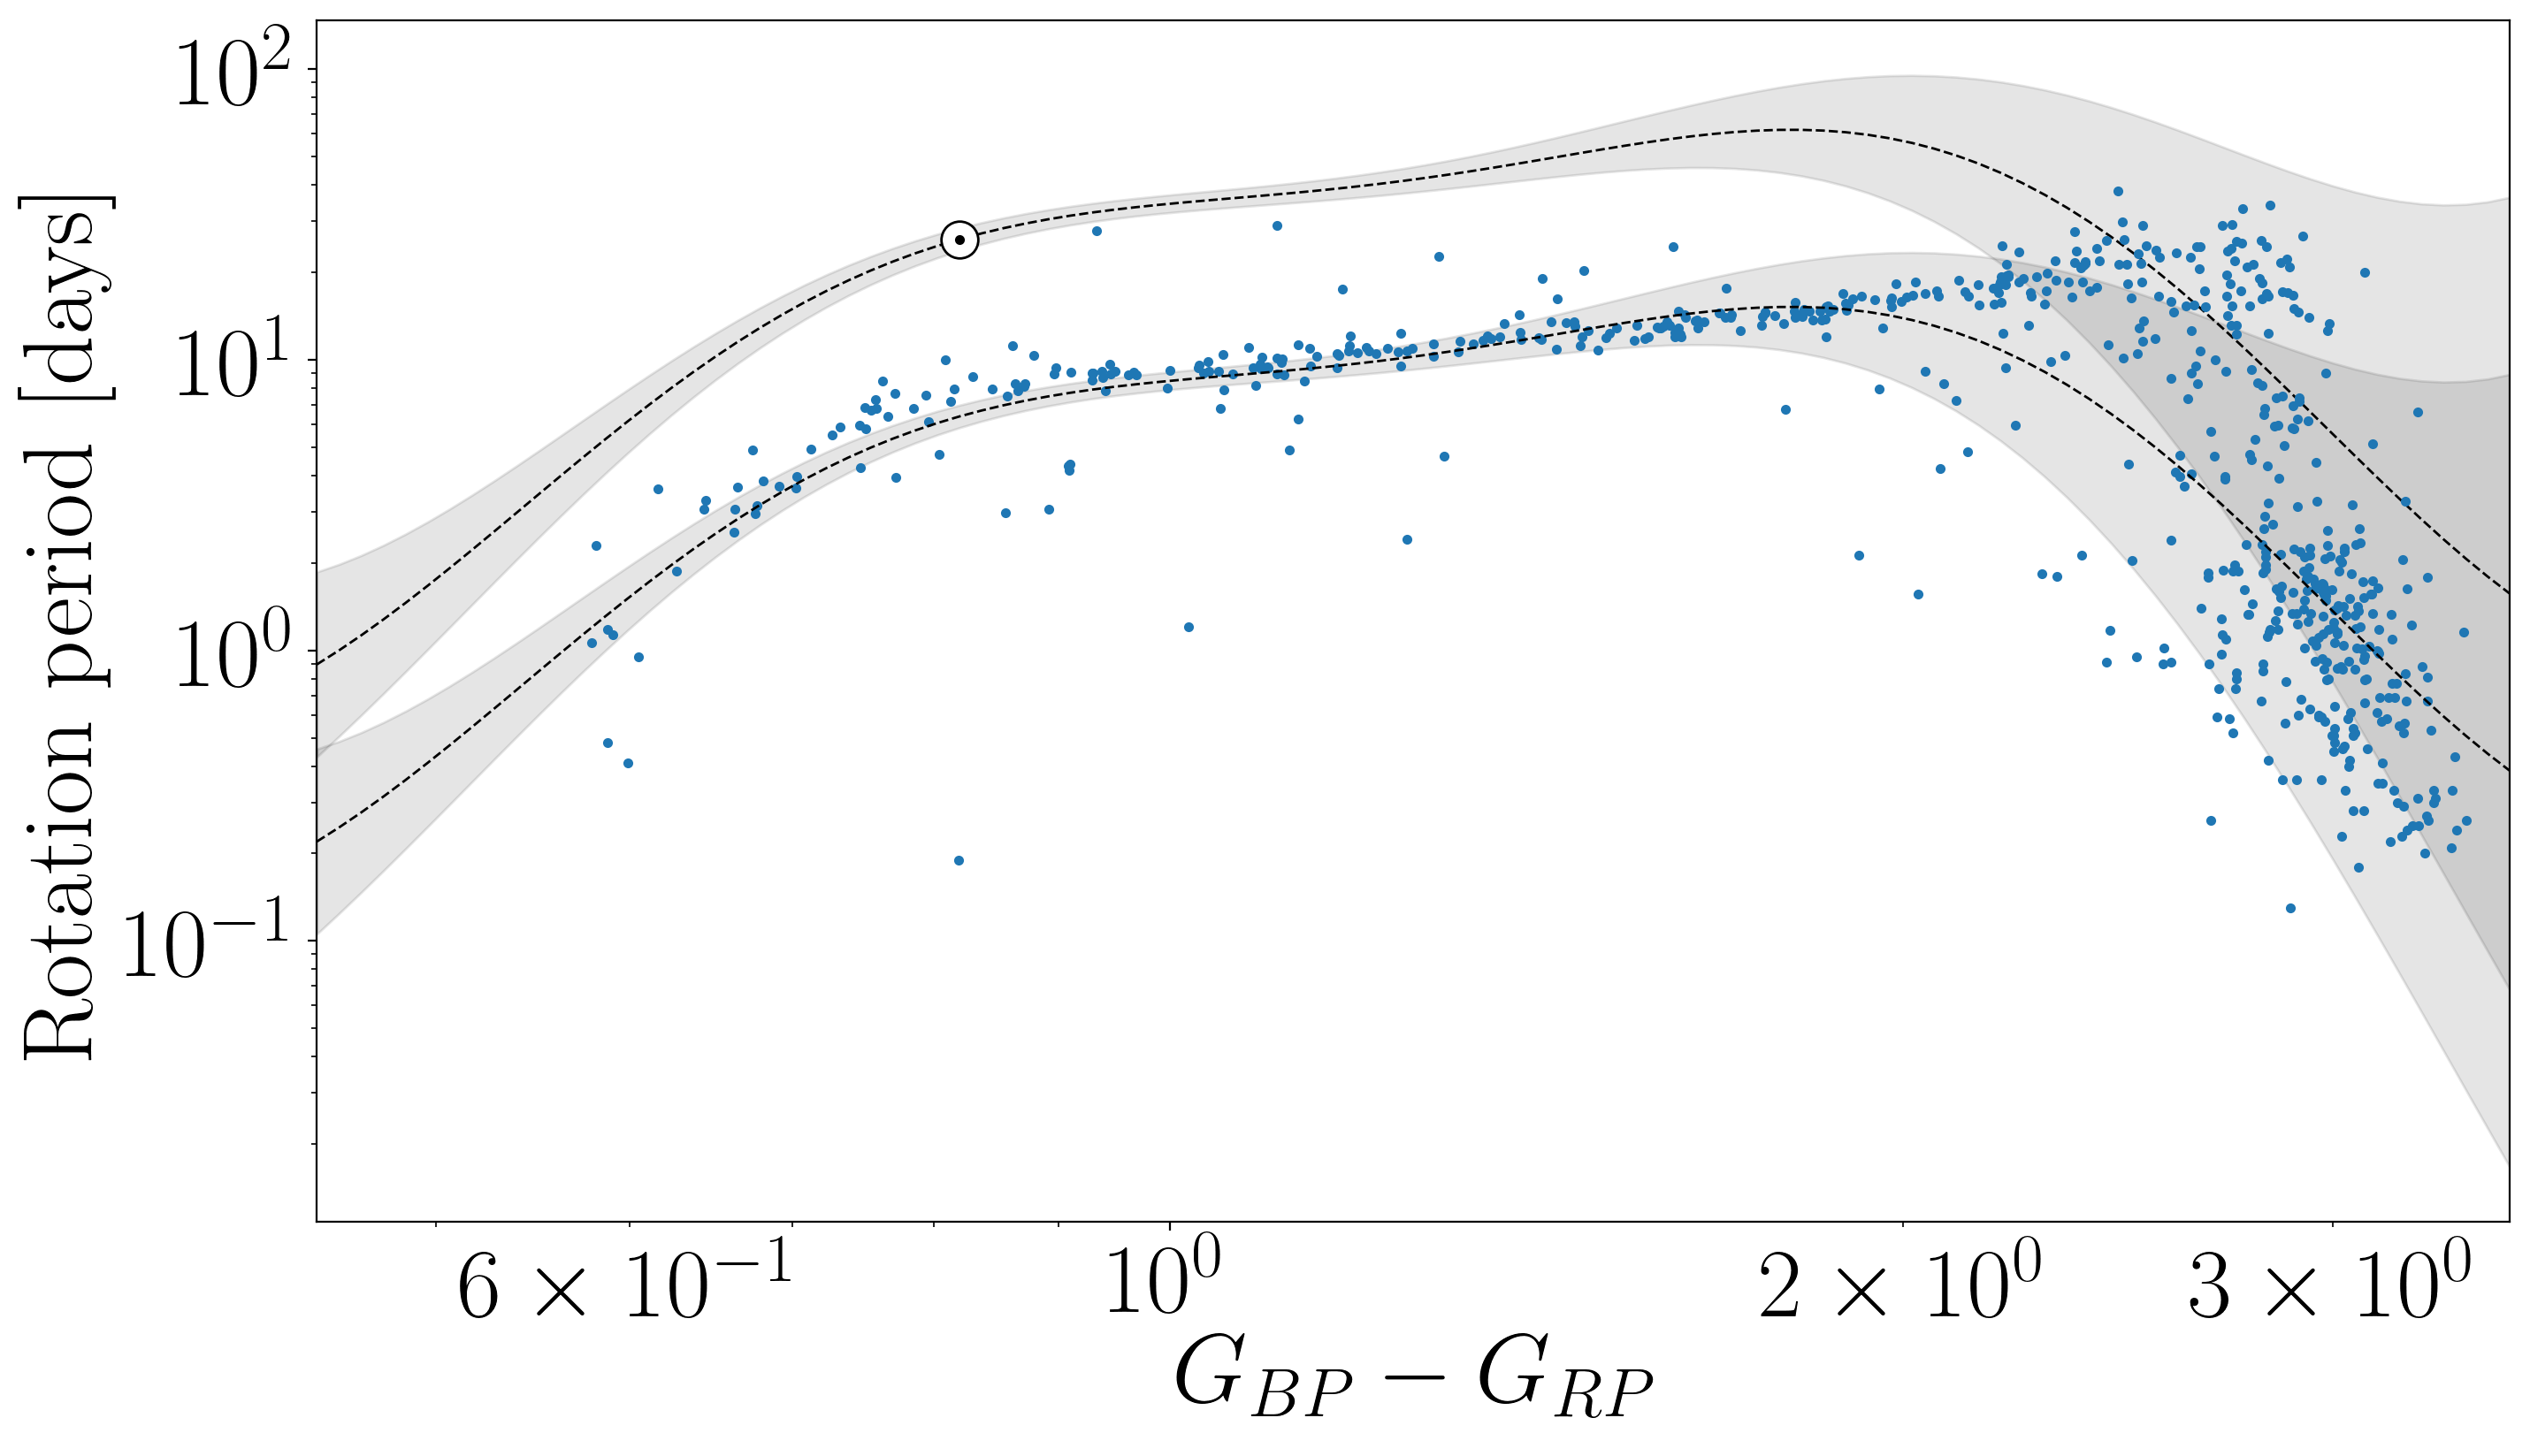

In [947]:
plt.figure(figsize=(16, 9), dpi=200)

plt.loglog(10**logbprp, 10**logp, ".")
plt.loglog(10**plot_x, 10**mean_praesepe, color="k", ls="--", lw=1, rasterized=True)
plt.fill_between(10**plot_x, 10**(mean_praesepe + plot_var), 10**(mean_praesepe - plot_var),
                 color="k", alpha=.1, rasterized=True)

plt.loglog(10**sun_color, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.loglog(10**sun_color, 10**sun_prot, ".k", zorder=2, rasterized=True)

plt.loglog(10**plot_x, 10**mean_sun, color="k", ls="--", lw=1, zorder=0, rasterized=True)
plt.fill_between(10**plot_x, 10**(mean_sun + plot_var), 10**(mean_sun - plot_var),
                 color="k", alpha=.1, rasterized=True)
plt.xlim(10**-.35, 10**.55)

plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$");